# Advanced deep learning supervised sentiment analyses based on movie reviews
## Based on 50,000 labeled IMDb movie reviews [dataset](http://ai.stanford.edu/~amaas/data/sentiment/)

# Import necessary depencencies

In [1]:
import pandas as pd
import numpy as np

# Python files with functions
import text_normalizer as tn
import model_evaluation_utils as meu
# ~Python files

np.set_printoptions(precision=2, linewidth=80)

# Load, split (train, test) and normalize the data

In [2]:
# Use subset of the data for better performance
train_size = 300
test_size = 1000

In [3]:
dataset = pd.read_csv('movie_reviews.csv').sample(frac=1).reset_index(
    drop=True)

reviews = np.array(dataset['review'])
sentiments = np.array(dataset['sentiment'])

# train sets
train_reviews = reviews[:train_size]
train_sentiments = sentiments[:train_size]

# test sets
test_reviews = reviews[train_size:train_size + test_size]
test_sentiments = sentiments[train_size:train_size + test_size]

# normalized reviews
norm_train_reviews = tn.normalize_corpus(train_reviews)
norm_test_reviews = tn.normalize_corpus(test_reviews)

# peek at data
print(dataset.head(1))

                                              review sentiment
0  I saw this with few expectations and absolutel...  positive


## Tokenize train and test data sets

In [5]:
tokenized_train = [tn.tokenizer.tokenize(text) for text in norm_train_reviews]
tokenized_test = [tn.tokenizer.tokenize(text) for text in norm_test_reviews]

# Build vocabulary mapping (word to index)

In [20]:
from collections import Counter

# build word to index vocabulary
token_counter = Counter(
    [token for review in tokenized_train for token in review])
vocab_map = {
    item[0]: index + 1
    for index, item in enumerate(dict(token_counter).items())
}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index + 1
vocab_size = len(vocab_map)

print('Vocabulary size: ', vocab_size)
print('Sample slice of vocabulary: ', dict(list(vocab_map.items())[10:20]))

Vocabulary size:  7387
Sample slice of vocabulary:  {'age': 11, 'movie': 12, 'atypical': 13, 'girl': 14, 'parminder': 15, 'nagra': 16, 'er': 17, 'breakout': 18, 'role': 19, 'play': 20}


# Encode and pad data sets and encode prediction class labels

In [34]:
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# get max length of train corpus and initialize label encoder
le = LabelEncoder()
num_classes = 2
max_len = np.max([len(review) for review in tokenized_train])

## Train reviews data corpus
# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review]
           for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len)  # pad
train_y = le.fit_transform(train_sentiments)

## Test reviews data corpus
# Convert tokenized text reviews to numeric vectors
test_X = [[
    vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX']
    for token in tokenized_review
] for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)  # pad
test_y = le.transform(test_sentiments)

print('Max review len: ',max_len)
print('Train matrix shape: ',train_X.shape,' Test matrix shape: ',test_X.shape)

Max review len:  469
Train matrix shape:  (300, 469)  Test matrix shape:  (1000, 469)


# Build the LSTM model architecture

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM

EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [37]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 469, 128)          945536    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 469, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 995,009
Trainable params: 995,009
Non-trainable params: 0
_________________________________________________________________
None


# Visualize model architecture

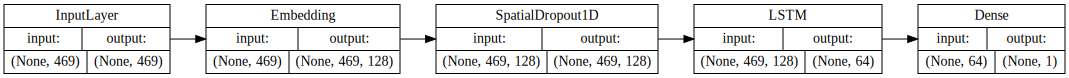

In [39]:
from IPython.display import SVG
from keras.utils.vis_utils import  model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='LR').create(prog='dot', format='svg'))

# Train the model

In [40]:
batch_size = 30
model.fit(train_X, train_y, epochs=5, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, verbose=1)

Train on 270 samples, validate on 30 samples
Epoch 1/5
270/270 [==============================] - ETA: 13s - loss: 0.6920 - acc: 0.53 - ETA: 7s - loss: 0.6923 - acc: 0.5167 - ETA: 5s - loss: 0.6937 - acc: 0.466 - ETA: 4s - loss: 0.6930 - acc: 0.475 - ETA: 3s - loss: 0.6935 - acc: 0.473 - ETA: 2s - loss: 0.6932 - acc: 0.477 - ETA: 1s - loss: 0.6932 - acc: 0.481 - ETA: 0s - loss: 0.6931 - acc: 0.487 - 6s 24ms/step - loss: 0.6931 - acc: 0.4889 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/5
270/270 [==============================] - ETA: 4s - loss: 0.6813 - acc: 0.900 - ETA: 3s - loss: 0.6825 - acc: 0.800 - ETA: 3s - loss: 0.6808 - acc: 0.811 - ETA: 2s - loss: 0.6813 - acc: 0.816 - ETA: 2s - loss: 0.6818 - acc: 0.800 - ETA: 1s - loss: 0.6809 - acc: 0.800 - ETA: 1s - loss: 0.6806 - acc: 0.800 - ETA: 0s - loss: 0.6799 - acc: 0.804 - 5s 19ms/step - loss: 0.6786 - acc: 0.8111 - val_loss: 0.6927 - val_acc: 0.5333
Epoch 3/5
270/270 [==============================] - ETA: 4s - loss: 0.6609 - acc:

# Predict and Evaluate Model Performance

In [41]:
pred_test = model.predict_classes(test_X)
predictions = le.inverse_transform(pred_test.flatten())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [42]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['positive', 'negative'])  

Model Performance metrics:
------------------------------
Accuracy: 0.692
Precision: 0.6991
Recall: 0.692
F1 Score: 0.6898

Model Classification report:
------------------------------
             precision    recall  f1-score   support

   positive       0.66      0.78      0.71       494
   negative       0.74      0.61      0.67       506

avg / total       0.70      0.69      0.69      1000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive        385      109
        negative        199      307
